# Pipeline

For each trial in paper sheet:
1) show trajectory
2) pick segment to analyze (between two straight points) = find coordinates + times of start and end
3) record day, start time, end time, crew, frequency, location, sea conditions -> in sheet
4) automatize calculations
    - from start time and end time, calculate speed, angle
    - update sheet with automatized data

Points 1), 2) and 3) are done my hand. Point 4) takes all the points from a `.csv` and completes the table.

## Trials to analyze
X 08.08.2023: Enora (possibly corrupted)              --> PRIORITY: check existence of data
- 08.08.2023: Skañv (possibly corrupted)              --> PRIORITY: check existence of data
- 04.09.2023: Logboat 7.5 - trials                    --> PRIORITY
- 04.09.2023: Logboat 6.5 - free navigation
- 05.09.2023: Logboat 7.5 - trials (afternoon)
- 05.09.2023: Logboat 6.5 - trials (afternoon)
- 26.09.2023: Skin boat
- 27.09.2023: Logboat (which?)

### Currently established tasks:
- [X] Check data of August for corruption
    - visualize trajectories
- [ ] General needs of analysis
    - add speed through water / currents to GPS to calculate total speed
- [ ] Logboat 7.5 trials
    - Produce tables with average speed (through water and GPS) and angle held for each trial
    - Produce examples of trajetories and polar diagrams of angles

## Visualization
First we import some stuff:

In [30]:
import os

import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
import hvplot.pandas 
import matplotlib.pyplot as plt

from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
from holoviews import opts

from processing import coordinate_conversion, concatenate_datasets
from plotting import cut_transect, plot_trajectory, plot_direction

import warnings
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom'], frame_width=500, frame_height=500))
hvplot_defaults = {'cmap':'Viridis', 'colorbar':True, 'figsize':(5,4)}

Let's import the datasets and create a unique pandas dataframe:

In [80]:
BASE_FOLDER = "/home/mtomasini/Documents/06_Development/01_Maritime_Encounters/Field_data/Navigation_Data/"
DATA_FOLDER = "230929/L/"
datasets = BASE_FOLDER + DATA_FOLDER + "composite_20240115_155516.n2kdecoded.csv"
datasets

full_data_raw = pd.read_csv(datasets, parse_dates = ['Time'], encoding='windows-1252', on_bad_lines='skip')

In [81]:
# full_data_raw['Time'] = full_data_raw['Time'] # .dt.time

full_data = cut_transect(full_data_raw, start_time="07:00")

position = full_data[full_data["Name"] == "Position, Rapid Update"].dropna(axis=1)
# clean up: e.g. there are data outside of the box, at 00 degrees Lat and 190 degrees Lon...
position = position[position["Latitude"].str.contains("48°")]
position = position[position["Longitude"].str.contains("04°")]

# plot trajectory on map showing also speed
plot_trajectory(position, with_speed=True)

Launching server at http://localhost:36711


## Trajectory analysis

We use `movingpandas` tooling to split the trajectories only when speed is above 1 m/s. We want to output the average speed along the transect, as well as the speed measured through the water and the bearing of the boat. Additionally, we can compute the difference between the bearing, the actual direction as measured by GPS movement, and the angle between starting point and ending point.

First we need to convert the dataframe to trajectories.

In [85]:
position['Converted Lat'] = position['Latitude'].apply(lambda x: coordinate_conversion(x))
position['Converted Lon'] = position['Longitude'].apply(lambda x: coordinate_conversion(x))
position_stripped = position[['Time', 'Converted Lat', 'Converted Lon']]
trajectory = mpd.Trajectory(position_stripped, traj_id = 'logboat', t='Time', x='Converted Lon', y='Converted Lat', crs="EPSG:4326")
# trajectory = mpd.MinTimeDeltaGeneralizer(trajectory).generalize(tolerance=timedelta(seconds=2))

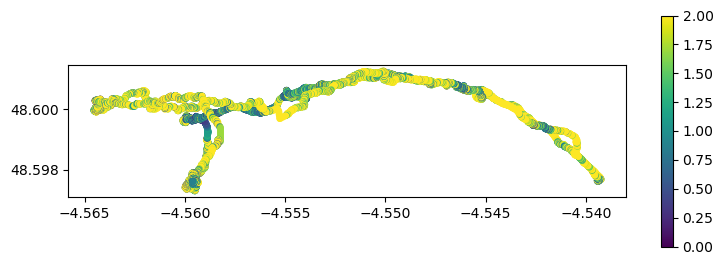

In [39]:
trajectory.plot(column='speed', vmax=2.0, **plot_defaults).get_figure().savefig('test.png')

Now let's split the whole trajectory in places where the vessel stays in the same place for at least 1 minute. Discard trajectories that are shorter than 100 meters long.

In [49]:
split = mpd.StopSplitter(trajectory).split(max_diameter=10, min_duration=timedelta(seconds=30), min_length=200)
split.to_traj_gdf()

,traj_id,start_t,end_t,geometry,length,direction
0,logboat_2024-01-15 12:53:29.001000,2024-01-15 12:53:29.001,2024-01-15 12:57:30.367,"LINESTRING (-4.55944 48.59786, -4.55943 48.597...",289.224702,5.393937
1,logboat_2024-01-15 13:25:27.996000,2024-01-15 13:25:27.996,2024-01-15 13:29:25.288,"LINESTRING (-4.55406 48.60034, -4.55407 48.600...",282.768317,53.318514
2,logboat_2024-01-15 13:30:37.019000,2024-01-15 13:30:37.019,2024-01-15 13:53:49.234,"LINESTRING (-4.55313 48.60078, -4.55312 48.600...",2362.710567,91.090580
3,logboat_2024-01-15 13:56:12.666000,2024-01-15 13:56:12.666,2024-01-15 14:24:50.425,"LINESTRING (-4.54652 48.60082, -4.54653 48.600...",3918.457202,250.105218
4,logboat_2024-01-15 14:26:23.995000,2024-01-15 14:26:23.995,2024-01-15 14:30:24.995,"LINESTRING (-4.55943 48.59774, -4.55943 48.597...",412.599652,165.549061


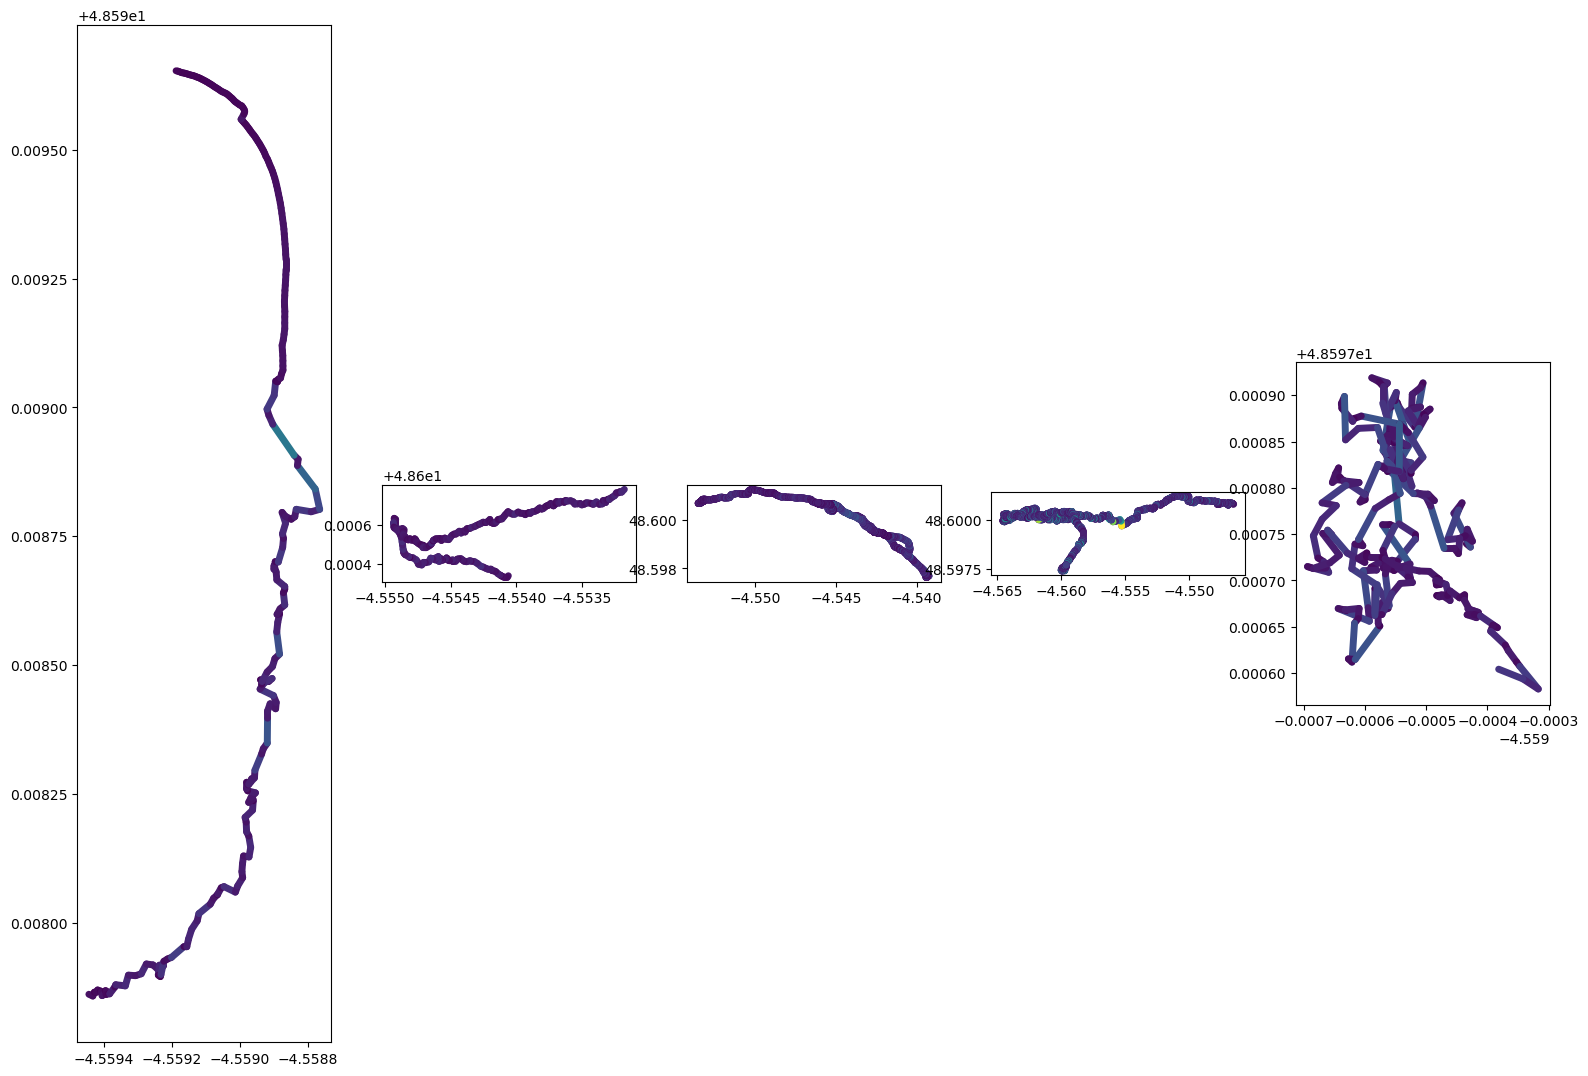

In [50]:
rows = 1
columns = int(len(split) / rows)
fig, axes = plt.subplots(nrows=1, ncols= len(split), figsize=(19,19))
for i, traj in enumerate(split):
    traj.plot(ax=axes[i], linewidth=5.0, capstyle='round', column='speed', vmax=20)

Another strategy would be to select those trajectories were speed is lower than a certain amount for a long period. 

In [7]:
split = mpd.SpeedSplitter(trajectory).split(speed=1, duration=timedelta(seconds=30), min_length=500)
split.to_traj_gdf()

,traj_id,start_t,end_t,geometry,length,direction
0,logboat_11,2024-01-12 09:41:02.847,2024-01-12 09:52:05.169,"LINESTRING (-3.54165 48.72950, -3.54165 48.729...",936.610383,299.698845
1,logboat_20,2024-01-12 10:06:49.855,2024-01-12 10:15:26.089,"LINESTRING (-3.55280 48.73351, -3.55281 48.733...",785.336933,354.234343


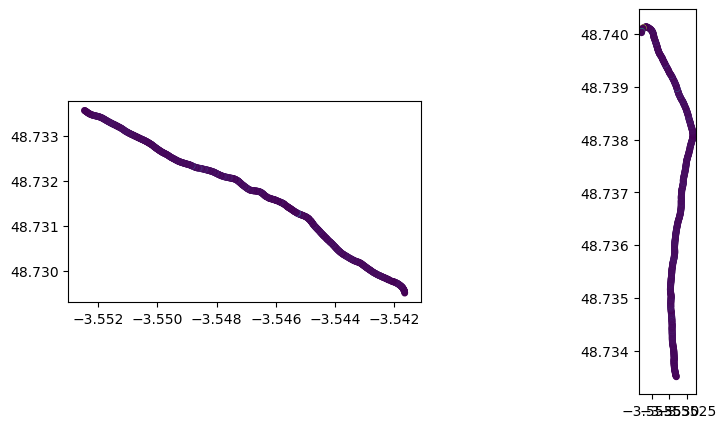

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=len(split), figsize=(10,5))
for i, traj in enumerate(split):
    traj.plot(ax=axes[i], linewidth=5.0, capstyle='round', column='speed', vmax=20)

This second strategy picked out what seem to be the two main trials that took place in the morning of 07/08. Now, from these we can extract speed over the transect, as well as angles, and all the tools we used so far.

So the strategy for each day of data is clear:

1) import `.csv` and create full trajectory
2) snip trajectory based on speed (stops are defined as parts of the trajectory where speed was lower than 1 m/s during at least 30 seconds)
3) extract start time and end time of each transect, with length of transect and direction held (that should be the angle between starting and ending point)
4) from start time and end time, other quantities can be calculated, such as winds, speed through water, vessel heading

Bonuses:
- I would like to do a plot showing for each step in time the vessel heading and the actual direction of movement. This would allow to show indirect effects of currents and winds.

In [34]:
exportable = split.to_traj_gdf()
exportable["duration"]= exportable.apply(lambda row: (row["end_t"] - row["start_t"]).total_seconds(), axis=1)
exportable

,traj_id,start_t,end_t,geometry,length,direction,duration
0,logboat_11,2024-01-12 09:41:02.847,2024-01-12 09:52:05.169,"LINESTRING (-3.54165 48.72950, -3.54165 48.729...",936.610383,299.698845,662.322
1,logboat_20,2024-01-12 10:06:49.855,2024-01-12 10:15:26.089,"LINESTRING (-3.55280 48.73351, -3.55281 48.733...",785.336933,354.234343,516.234


Let's try to use the stop splitter:

In [68]:
split = mpd.StopSplitter(trajectory).split(min_duration=timedelta(seconds=60), 
                                           max_diameter=50, 
                                           min_length=300)
split.to_traj_gdf()


,traj_id,start_t,end_t,geometry,length,direction
0,logboat_2024-01-15 13:32:35,2024-01-15 13:32:35.000,2024-01-15 13:35:54.422,"LINESTRING (-4.55297 48.60082, -4.55295 48.600...",318.115477,83.289888
1,logboat_2024-01-15 13:36:56.998000,2024-01-15 13:36:56.998,2024-01-15 13:44:38.048,"LINESTRING (-4.54870 48.60103, -4.54869 48.601...",864.788494,116.900270
2,logboat_2024-01-15 13:58:20.335000,2024-01-15 13:58:20.335,2024-01-15 14:11:49.997,"LINESTRING (-4.54783 48.60095, -4.54791 48.600...",2055.562783,265.128770
3,logboat_2024-01-15 14:15:22.992000,2024-01-15 14:15:22.992,2024-01-15 14:23:11.094,"LINESTRING (-4.56386 48.60021, -4.56385 48.600...",1039.707805,131.885289


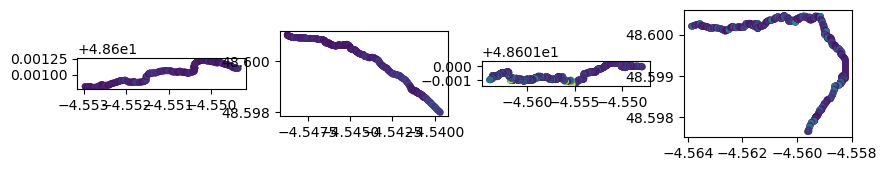

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=len(split), figsize=(10,5))
for i, traj in enumerate(split):
    traj.plot(ax=axes[i], linewidth=5.0, capstyle='round', column='speed', vmax=20)

-----

EVERYTHING BELOW HERE IS FOR NOW OBSOLETE

Now we show the trajectory, using `geopandas`:

In [6]:
position = full_data[full_data["Name"] == "Position, Rapid Update"].dropna(axis=1)
position = position[-position["Latitude"].str.contains("00°")]
# position = cut_transect(position, "10:07:", "10:14:")

timepoint = datetime(2024, 1, 4, 9, 1, 0)

plot_trajectory(position, timepoint = timepoint)

AttributeError: 'Overlay' object has no attribute set_aspect.

In [45]:
start = traj.get_start_time().strftime("%H:%M:%S")
trans = cut_transect(full_data, start)
trans

,Line,Time,Type,PGN,Name,Src,Dest,Pri,Size,Sequence ID,...,Type of System,Method GNSS,Integrity,NMEA Reserved.5,Number of SVs,HDOP,PDOP,Geoidal Separation,Number of Reference Stations,Unnamed: 49
88619,88619,2024-01-12 10:06:49.102,CANPACKET,130306,Wind Data,92,255,6,8,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88620,88620,2024-01-12 10:06:49.110,CANPACKET,127250,Vessel Heading,0,255,2,8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88621,88621,2024-01-12 10:06:49.111,CANPACKET,128259,"Speed, Water Referenced",0,255,2,8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88622,88622,2024-01-12 10:06:49.116,CANPACKET,127250,Vessel Heading,225,255,2,8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88623,88623,2024-01-12 10:06:49.202,CANPACKET,130306,Wind Data,92,255,6,8,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97792,97792,2024-01-12 10:15:28.000,CANPACKET,127250,Vessel Heading,0,255,2,8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97793,97793,2024-01-12 10:15:28.000,CANPACKET,128259,"Speed, Water Referenced",0,255,2,8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97794,97794,2024-01-12 10:15:28.271,CANPACKET,127250,Vessel Heading,0,255,2,8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97795,97795,2024-01-12 10:15:28.276,CANPACKET,127250,Vessel Heading,232,255,2,8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The mean speed through the water over the transect is:

In [88]:
speed_water_ref = full_data[full_data["Name"] == "Speed, Water Referenced"].dropna(axis=1)
full_data.Name.unique()
# print(f"Time of last position {position['Time'].iloc[-1]} \n Time of last speed {speed_water_ref['Time'].iloc[-1]}")
#speed_water_ref_transect = cut_transect(speed_water_ref, "10:06:49", "10:15:26")

#speed_water_ref_transect["Speed Water Referenced"].plot()

array(['Vessel Heading', 'System Time', 'COG & SOG, Rapid Update',
       'Position, Rapid Update', 'GNSS Position Data',
       'ISO Address Claim', 'Product Information', 'Heartbeat',
       'GNSS DOPs', 'GNSS Sats in View', 'Attitude', 'Rate of Turn',
       'ISO Request', 'Wind Data'], dtype=object)

In [84]:
wind_data = full_data[full_data["Name"] == "Wind Data"].dropna(axis=1)
wind_data["Wind Direction"]

88       4.4783
89       4.4783
92       4.4958
93       4.5133
94       4.5308
          ...  
96794    4.0760
96796    4.1109
96798    4.1284
96799    4.1109
96803    4.0934
Name: Wind Direction, Length: 45478, dtype: float64

We also want to show the speed over the transect, as well as the direction kept in time.

In [96]:
direction = full_data[full_data["Name"] == "Vessel Heading"].dropna(axis=1)
direction = cut_transect(direction, "10:06:00", "10:14:00")

# fig = plot_direction(full_data, "10:07:", "10:11:")

In [95]:
full_data["Name"].unique()

array(['Wind Data', 'Vessel Heading', 'Speed, Water Referenced',
       'COG & SOG, Rapid Update', 'Position, Rapid Update',
       'GNSS Position Data'], dtype=object)